In [105]:
%store -r X
%store -r Y
import pandas as pd
import numpy as np
import lime
from lime import lime_tabular
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt

In [122]:
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
import warnings
from mlxtend.classifier import StackingClassifier
import missingno as msno
from sklearn.ensemble import VotingClassifier
import shap
shap.initjs()
import lime
from lime import lime_tabular
warnings.simplefilter('ignore')
import os
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

In [20]:
import sys
!{sys.executable} -m pip install RandomForestClassifier

ERROR: Could not find a version that satisfies the requirement RandomForestClassifier (from versions: none)
ERROR: No matching distribution found for RandomForestClassifier


In [10]:
# Filling remaining missing values with mean
X = X.fillna(X.mean())

In [11]:
# Train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state=1)

In [12]:
# Check the shape of train dataset
print(X_train.shape,Y_train.shape)

# Check the shape of test dataset
print(X_test.shape, Y_test.shape)

(44535, 121) (44535,)
(14846, 121) (14846,)


In [25]:
# Utility Functions
def check_scores(model, X_train, X_test ):
  # Making predictions on train and test data

  train_class_preds = model.predict(X_train)
  test_class_preds = model.predict(X_test)


  # Get the probabilities on train and test
  train_preds = model.predict_proba(X_train)[:,1]
  test_preds = model.predict_proba(X_test)[:,1]


  # Calculating accuracy on train and test
  train_accuracy = accuracy_score(Y_train,train_class_preds)
  test_accuracy = accuracy_score(Y_test,test_class_preds)

  print("The accuracy on train dataset is", train_accuracy)
  print("The accuracy on test dataset is", test_accuracy)
  print()
  # Get the confusion matrices for train and test
  train_cm = confusion_matrix(Y_train,train_class_preds)
  test_cm = confusion_matrix(Y_test,test_class_preds )

  print('Train confusion matrix:')
  print( train_cm)
  print()
  print('Test confusion matrix:')
  print(test_cm)
  print()

  # Get the roc_auc score for train and test dataset
  train_auc = roc_auc_score(Y_train,train_preds)
  test_auc = roc_auc_score(Y_test,test_preds)

  print('ROC on train data:', train_auc)
  print('ROC on test data:', test_auc)
  
  # Fscore, precision and recall on test data
  f1 = f1_score(Y_test, test_class_preds)
  precision = precision_score(Y_test, test_class_preds)
  recall = recall_score(Y_test, test_class_preds) 
  
  
  #R2 score on train and test data
  train_log = log_loss(Y_train,train_preds)
  test_log = log_loss(Y_test, test_preds)

  print()
  print('Train log loss:', train_log)
  print('Test log loss:', test_log)
  print()
  print("F score is:",f1 )
  print("Precision is:",precision)
  print("Recall is:", recall)
  return model, train_auc, test_auc, train_accuracy, test_accuracy,f1, precision,recall, train_log, test_log


def check_importance(model, X_train):
  #Checking importance of features
  importances = model.feature_importances_
  
  #List of columns and their importances
  importance_dict = {'Feature' : list(X_train.columns),
                    'Feature Importance' : importances}
  #Creating a dataframe
  importance_df = pd.DataFrame(importance_dict)
  
  #Rounding it off to 2 digits as we might get exponential numbers
  importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
  return importance_df.sort_values(by=['Feature Importance'],ascending=False)

def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model



# This function will show how a feature is pushing towards 0 or 1
def interpret_with_lime(model, X_test):
  # New data
  interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='classification')
  

  exp = interpretor.explain_instance(
      data_row=X_test.iloc[10], 
      predict_fn=model.predict_proba
  )

  exp.show_in_notebook(show_table=True)

# This gives feature importance
def plot_feature_importance(model, X_train):
  # PLotting features vs their importance factors
  fig = plt.figure(figsize = (15, 8))
  
  # Extracting importance values
  values =check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature Importance'].values
  
  
  # Extracting importance features
  features = check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature'].values

  plt.bar(features, values, color ='blue',
          width = 0.4)
  plt.xticks( rotation='vertical')
  plt.show()

In [26]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# Hyperparameter Grid
rf_parameters = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

print(rf_parameters)

#finding the best model
rf_optimal_model = grid_search(RandomForestClassifier(), rf_parameters, X_train, Y_train)

{'n_estimators': [50, 80, 100], 'max_depth': [4, 6, 8], 'min_samples_split': [50, 100, 150], 'min_samples_leaf': [40, 50]}
Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   0.6s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV

In [43]:
# Getting scores from all the metrices
rf_model, rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_f1, rf_precision,rf_recall,rf_train_log, rf_test_log = check_scores(rf_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.8099023240148198
The accuracy on test dataset is 0.801697426916341

Train confusion matrix:
[[27146  2761]
 [ 5705  8923]]

Test confusion matrix:
[[9042  943]
 [2001 2860]]

ROC on train data: 0.8922696728466395
ROC on test data: 0.885280955788754

Train log loss: 0.42414990742473685
Test log loss: 0.4293597191800434

F score is: 0.6602031394275162
Precision is: 0.7520378648435446
Recall is: 0.588356305286978


In [46]:
# Getting the feature importance for all the features
check_importance(rf_model, X_train)

Feature  Feature Importance
10                  BMI                0.22
9                    Wt                0.19
87   Medical_Keyword_15                0.12
56   Medical_History_23                0.10
39    Medical_History_4                0.09
..                  ...                 ...
43    Medical_History_8                0.00
42    Medical_History_7                0.00
41    Medical_History_6                0.00
40    Medical_History_5                0.00
120  Medical_Keyword_48                0.00

[121 rows x 2 columns]

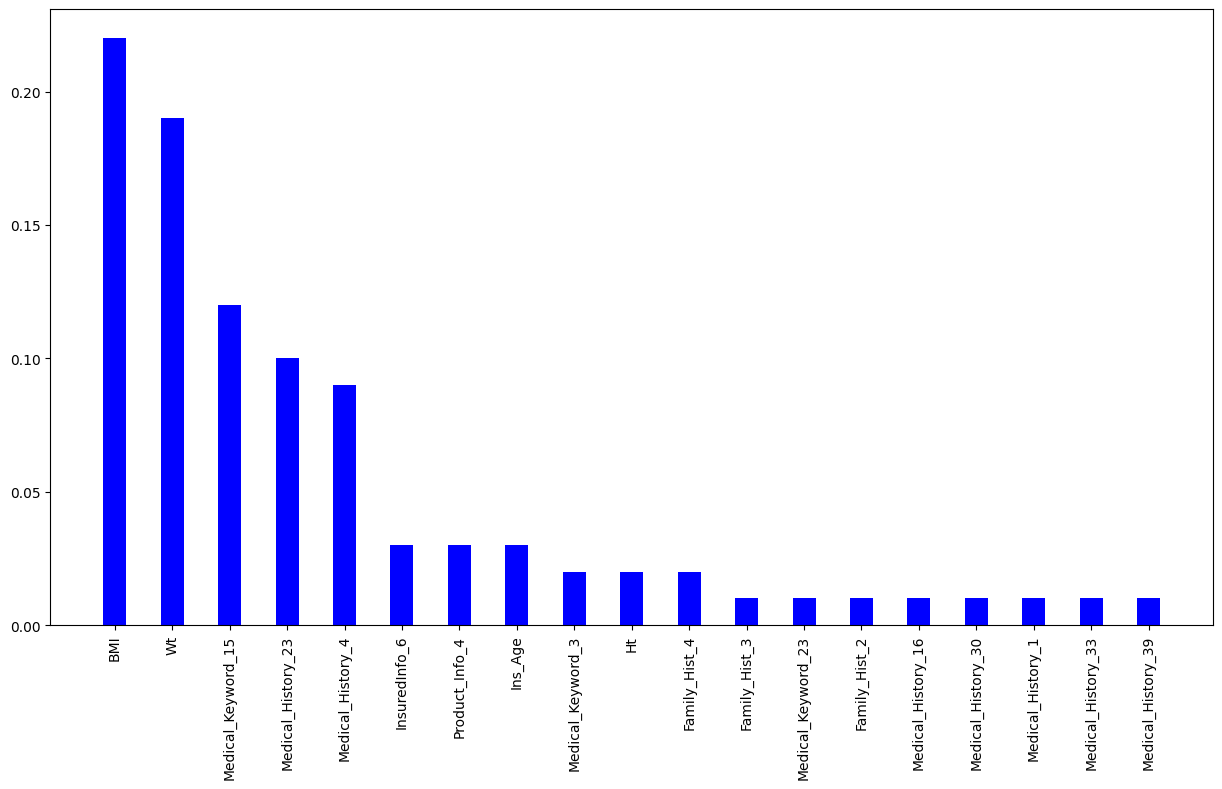

In [49]:
# PLotting only those features which are contributing something
plot_feature_importance(rf_model, X_train)

In [61]:
# Interpretting the model using lime
interpret_with_lime(rf_model,X_test)

/Users/shantandadi/miniconda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


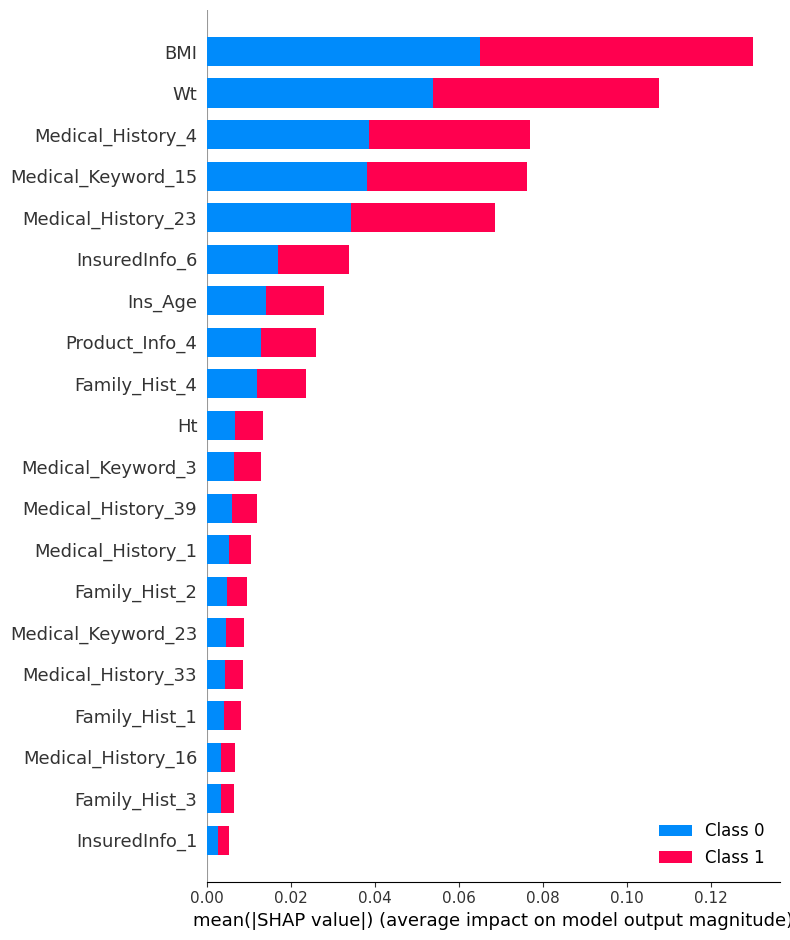

In [64]:
# Interpretting the model using shaply
X_shap=X_train

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_shap)
shap.summary_plot(rf_shap_values, X_shap, plot_type="bar")

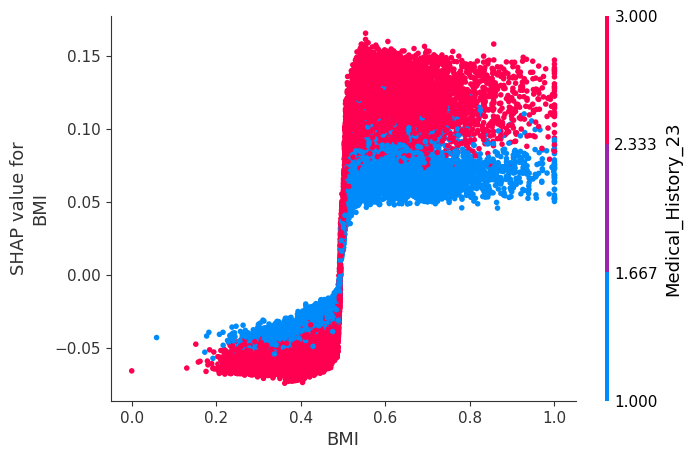

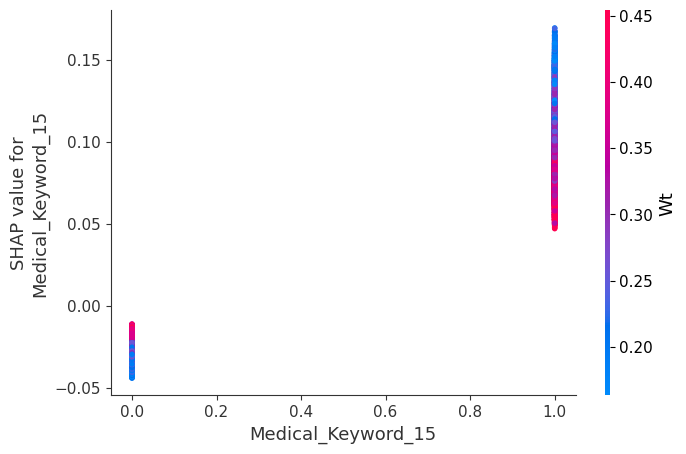

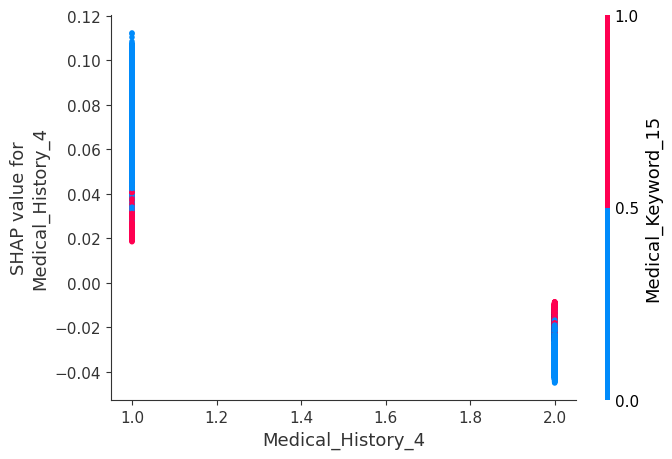

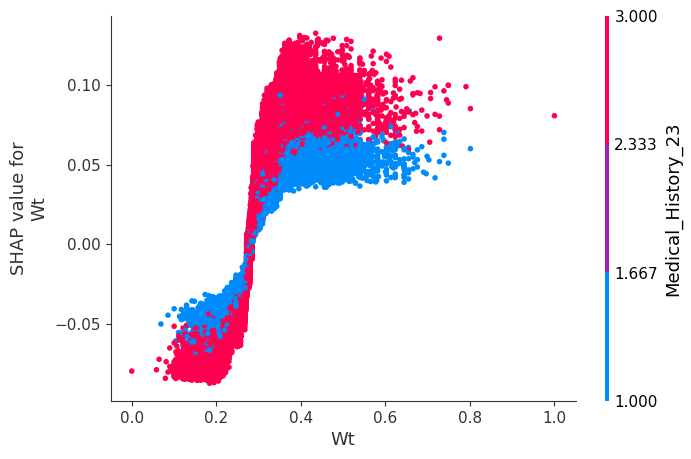

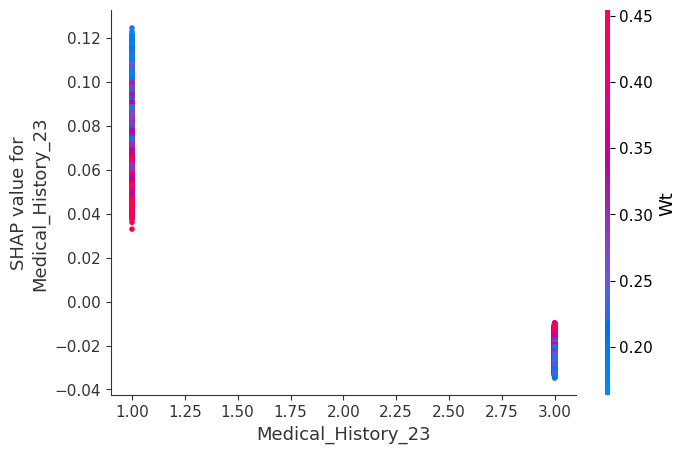

In [66]:
# Plotting for top 5 features
top_vars = ['BMI','Medical_Keyword_15','Medical_History_4','Wt','Medical_History_23']
index_top_vars =[list(X_train.columns).index(var) for var in top_vars]

for elem in index_top_vars:
    shap.dependence_plot(elem, rf_shap_values[0], X_train)

In [70]:
#finding the best model
gb_parameters ={
    "n_estimators":[5,50,250],
    "max_depth":[1,3,5,7],
    "learning_rate":[0.01,0.1,1]
}

print(gb_parameters)

gb_optimal_model = grid_search(GradientBoostingClassifier(), gb_parameters, X_train, Y_train)

{'n_estimators': [5, 50, 250], 'max_depth': [1, 3, 5, 7], 'learning_rate': [0.01, 0.1, 1]}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=5; total time=   0.2s
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=   4.3s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=5; total time=   0.3s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=5; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   2.5s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   2.4s
[CV] END ..learning_rate=0.01, max_dep

In [71]:
# Getting the scpres for all the score metrics used here
gb_model, gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_f1, gb_precision,gb_recall,gb_train_log, gb_test_log = check_scores(gb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.8662849444257326
The accuracy on test dataset is 0.832547487538731

Train confusion matrix:
[[26693  3214]
 [ 2741 11887]]

Test confusion matrix:
[[8705 1280]
 [1206 3655]]

ROC on train data: 0.9392406794670259
ROC on test data: 0.90910506883551

Train log loss: 0.3007472224726789
Test log loss: 0.3540729438343199

F score is: 0.7462229481420989
Precision is: 0.7406281661600811
Recall is: 0.7519029006377289


In [72]:
# Getting feature importance
check_importance(gb_model, X_train)

Feature  Feature Importance
10                  BMI                0.39
56   Medical_History_23                0.14
39    Medical_History_4                0.13
3        Product_Info_4                0.05
87   Medical_Keyword_15                0.03
..                  ...                 ...
46   Medical_History_12                0.00
45   Medical_History_11                0.00
44    Medical_History_9                0.00
43    Medical_History_8                0.00
120  Medical_Keyword_48                0.00

[121 rows x 2 columns]

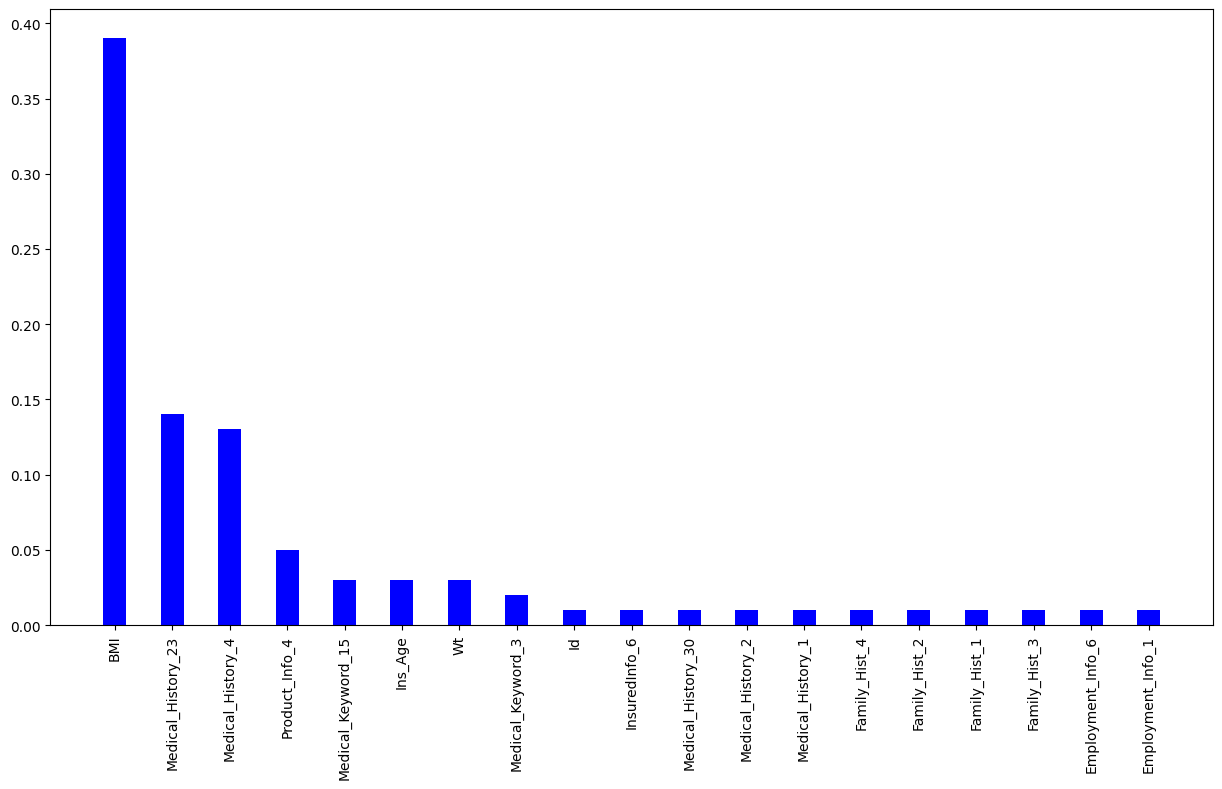

In [73]:

# PLotting only those features which are contributing something
plot_feature_importance(gb_model, X_train)


In [74]:
# Interpretting the model using lime
interpret_with_lime(gb_model,X_test)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


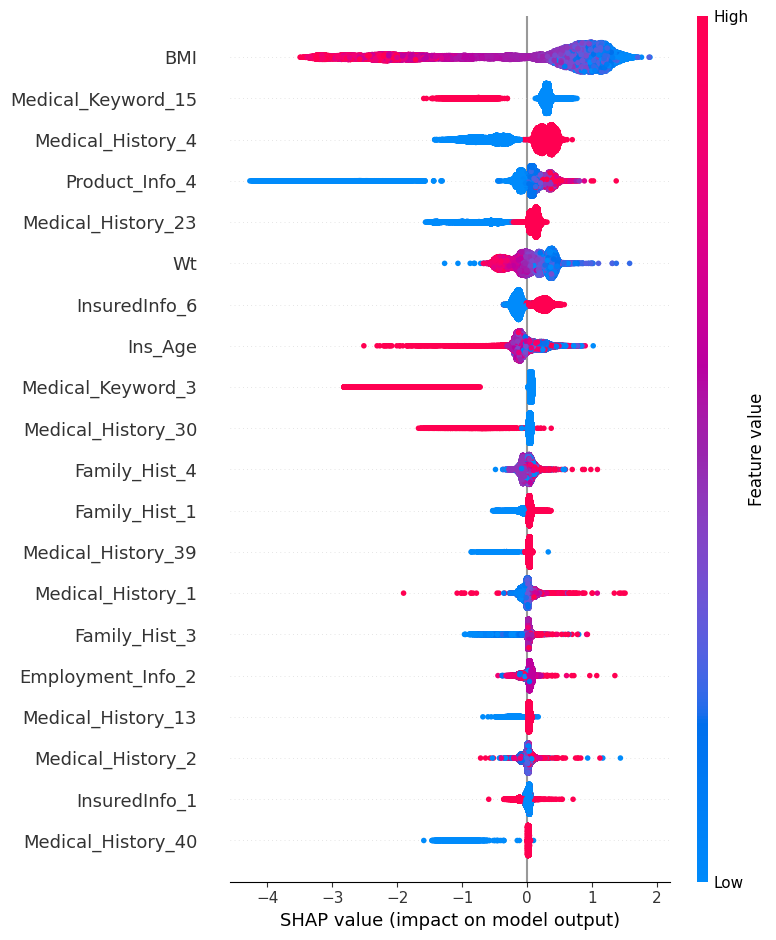

In [75]:
# Interpretting the model using shaply
X_shap=X_train

gb_explainer = shap.TreeExplainer(gb_model)
gb_shap_values = gb_explainer.shap_values(X_shap)
shap.summary_plot(gb_shap_values, X_shap, plot_type="dot")

In [81]:
# Parameter grid for xgboost
xgb_parameters = {'max_depth': [1,3,5], 'n_estimators': [2,5,10], 'learning_rate': [.01 , .1, .5]}
print('XGB parameters areL:')
print(xgb_parameters)
#finding the best model
xgb_optimal_model = grid_search(XGBClassifier(), xgb_parameters, X_train, Y_train)

XGB parameters areL:
{'max_depth': [1, 3, 5], 'n_estimators': [2, 5, 10], 'learning_rate': [0.01, 0.1, 0.5]}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=2; total time=   0.2s
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=2; total time=   0.0s
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=5; total time=   0.1s
[CV] END ....learning_rate=0.01, max_depth=1, n_estimators=5; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=2; total time=   0.1s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=2; total time=   0.1s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=5; total time=   0.1s
[CV] END ....learning_rate=0.01, max_depth=3, n_estimators=5; total time=   0.1s
[CV] END ...learning

In [82]:

# Getting the scores for all the score metrics used here
xgb_model, xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_f1, xgb_precision,xgb_recall,xgb_train_log, xgb_test_log= check_scores(xgb_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.8292803413045919
The accuracy on test dataset is 0.824397144011855

Train confusion matrix:
[[25660  4247]
 [ 3356 11272]]

Test confusion matrix:
[[8559 1426]
 [1181 3680]]

ROC on train data: 0.9065207832001382
ROC on test data: 0.9010630840315195

Train log loss: 0.3607049840425798
Test log loss: 0.3693317117849015

F score is: 0.7384368415772047
Precision is: 0.7207207207207207
Recall is: 0.7570458753342934


In [83]:
# Getting feature importance

check_importance(xgb_model, X_train)

Feature  Feature Importance
10                  BMI                0.17
56   Medical_History_23                0.14
39    Medical_History_4                0.13
75    Medical_Keyword_3                0.06
62   Medical_History_30                0.05
..                  ...                 ...
44    Medical_History_9                0.00
43    Medical_History_8                0.00
42    Medical_History_7                0.00
41    Medical_History_6                0.00
120  Medical_Keyword_48                0.00

[121 rows x 2 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


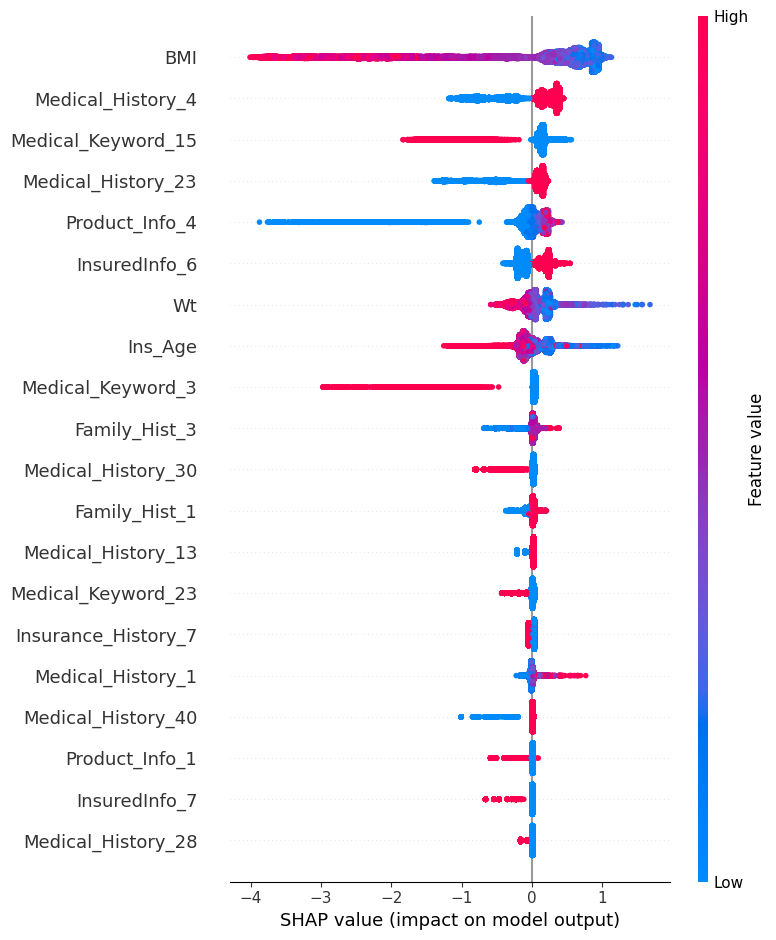

In [84]:
# Interpretting the model using shaply

xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_shap)
shap.summary_plot(xgb_shap_values, X_shap, plot_type="dot")

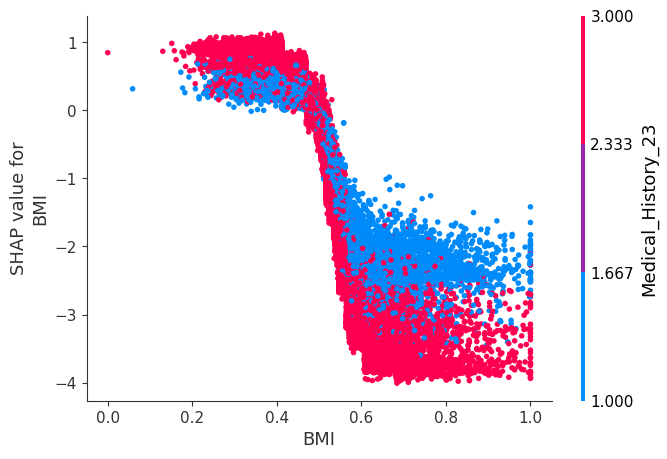

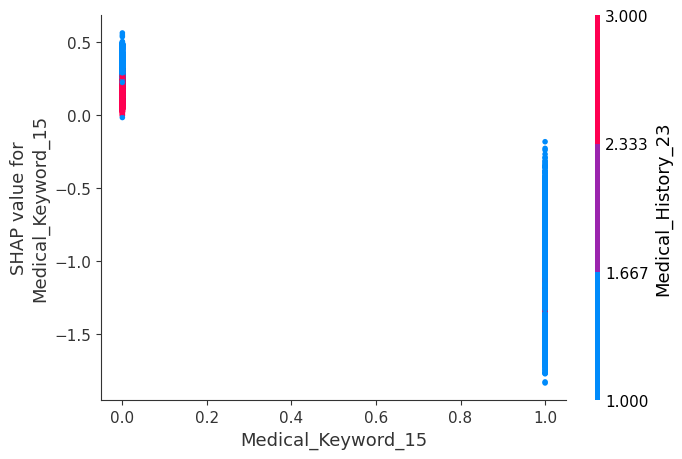

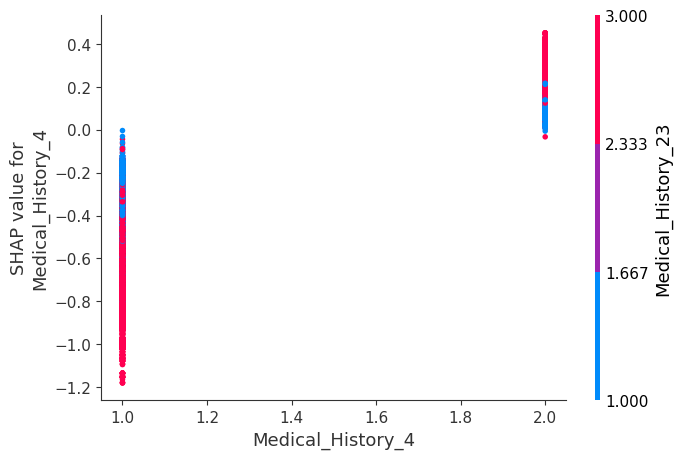

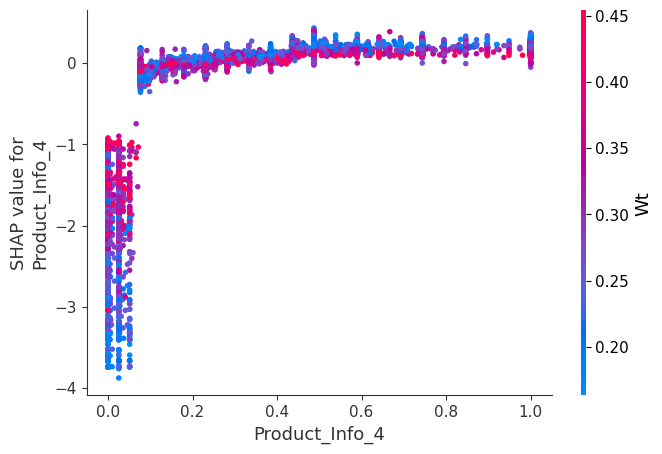

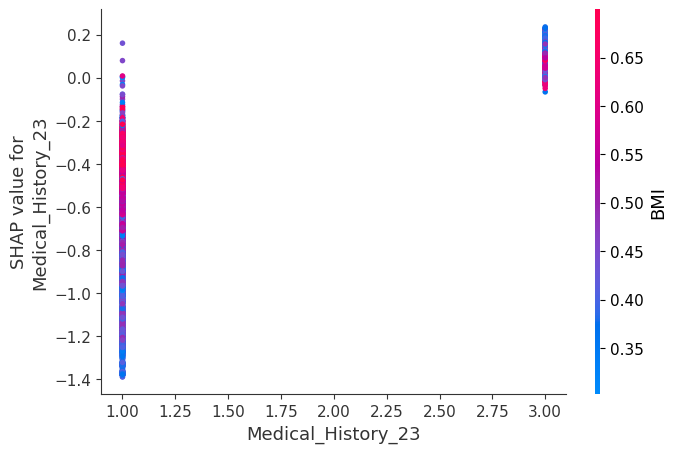

In [85]:
#PLotting for top 5 features
top_vars = ['BMI','Medical_Keyword_15','Medical_History_4','Product_Info_4','Medical_History_23']
index_top_vars =[list(X_train.columns).index(var) for var in top_vars]

for elem in index_top_vars:
    shap.dependence_plot(elem, xgb_shap_values, X_train)

In [89]:
# Parameter grid for Logistic Regression
solvers = ['lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
lr_parameters = dict(solver=solvers,penalty=penalty,C=c_values)# define grid search

#finding the best model
lr_optimal_model = grid_search(LogisticRegression( max_iter=5000), lr_parameters, X_train, Y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.8s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.2s


Best parameters are: 
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [90]:
# Getting the scores for all the score metrics used here

lr_model, lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_f1, lr_precision, lr_recall,lr_train_log, lr_test_log = check_scores(lr_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.7446502750645559
The accuracy on test dataset is 0.7439714401185504

Train confusion matrix:
[[25653  4254]
 [ 7118  7510]]

Test confusion matrix:
[[8566 1419]
 [2382 2479]]

ROC on train data: 0.796446070138549
ROC on test data: 0.7938132254955154

Train log loss: 0.5062957265451913
Test log loss: 0.5064630202117298

F score is: 0.5660463523233246
Precision is: 0.6359671626475115
Recall is: 0.5099773709113351


In [91]:
# Getting the scores for all the score metrics used here

lr_model, lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_f1, lr_precision, lr_recall,lr_train_log, lr_test_log = check_scores(lr_optimal_model, X_train, X_test )

The accuracy on train dataset is 0.7446502750645559
The accuracy on test dataset is 0.7439714401185504

Train confusion matrix:
[[25653  4254]
 [ 7118  7510]]

Test confusion matrix:
[[8566 1419]
 [2382 2479]]

ROC on train data: 0.796446070138549
ROC on test data: 0.7938132254955154

Train log loss: 0.5062957265451913
Test log loss: 0.5064630202117298

F score is: 0.5660463523233246
Precision is: 0.6359671626475115
Recall is: 0.5099773709113351


In [92]:
# Making a dataframe with coefficients and the feature names respectively
importance_df_lr = pd.concat([ pd.DataFrame(data =((X_train.columns).values).reshape(-1,1), columns = ['Feature']), pd.DataFrame(data =np.round(lr_optimal_model.coef_,2).reshape(-1,1), columns = ['Feature Importance'])], axis=1 )
importance_df_lr.sort_values(by=['Feature Importance'],ascending=False, inplace = True)
importance_df_lr

Feature  Feature Importance
56  Medical_History_23                1.06
39   Medical_History_4                0.58
22       InsuredInfo_6                0.33
70  Medical_History_39                0.26
3       Product_Info_4                0.24
..                 ...                 ...
5       Product_Info_6               -0.20
13   Employment_Info_3               -0.23
10                 BMI               -0.30
49  Medical_History_16               -0.38
87  Medical_Keyword_15               -0.54

[121 rows x 2 columns]

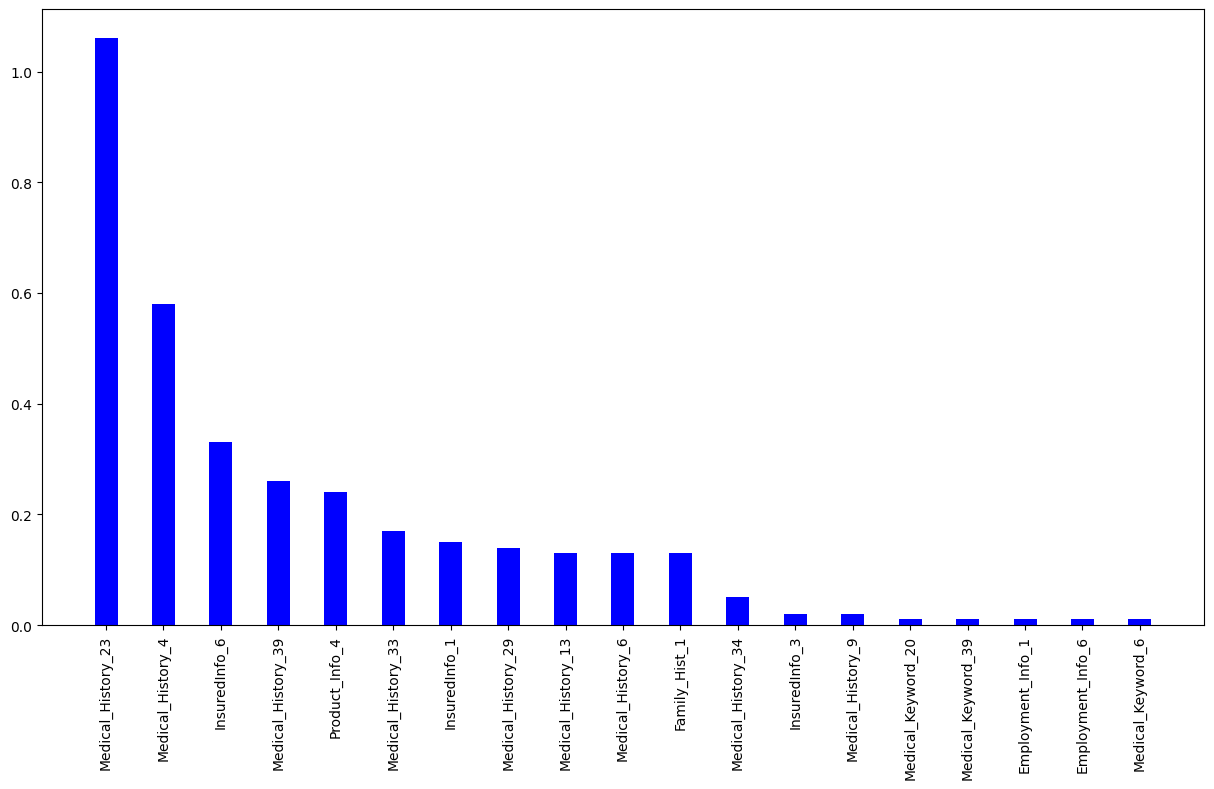

In [93]:
# Plotting feature vs importance
fig = plt.figure(figsize = (15, 8))

values =importance_df_lr[importance_df_lr['Feature Importance']>0]['Feature Importance'].values

features = importance_df_lr[importance_df_lr['Feature Importance']>0]['Feature'].values

plt.bar(features, values, color ='blue',
          width = 0.4)
plt.xticks( rotation='vertical')
plt.show()

In [94]:
# Interpretting the model using lime
interpret_with_lime(lr_model,X_test)

X does not have valid feature names, but LogisticRegression was fitted with feature names


In [97]:
# Appending all the models to estimators list
estimators = []

estimators.append(('logistic', lr_optimal_model))
estimators.append(('XGB', xgb_optimal_model))
estimators.append(('GB', gb_optimal_model))
estimators.append(('rf', rf_optimal_model))

# create the voting model
voting_model = VotingClassifier(estimators, voting='soft')

voting_model.fit(X_train, Y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.01, max_iter=5000)),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_...
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=5,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=10, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...)),
                             ('GB',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=250)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     min_samples_leaf=40,
                                                     min_samples_split=100))],
                 voting='soft')

In [98]:
# Getting all the scores and errors
voting_model, voting_train_auc, voting_test_auc, voting_train_accuracy, voting_test_accuracy, voting_f1, voting_precision, voting_recall, voting_train_log, voting_test_log = check_scores(voting_model, X_train, X_test )

The accuracy on train dataset is 0.8389356685752779
The accuracy on test dataset is 0.8270241142395258

Train confusion matrix:
[[26758  3149]
 [ 4024 10604]]

Test confusion matrix:
[[8873 1112]
 [1456 3405]]

ROC on train data: 0.9157229220811477
ROC on test data: 0.9000452540567692

Train log loss: 0.3792068478483053
Test log loss: 0.39507369674263

F score is: 0.7261676263595649
Precision is: 0.7538189063537746
Recall is: 0.700473153672084


In [123]:
#Building a stacked classifier
stacked_classifier = StackingClassifier(classifiers =[lr_optimal_model, xgb_optimal_model, gb_model], meta_classifier = RandomForestClassifier(), use_probas = True, use_features_in_secondary = True)

# training of stacked model
stacked_model = stacked_classifier.fit(X_train, Y_train)

In [124]:
stacked_model, stacked_train_auc, stacked_test_auc, stacked_train_accuracy, stacked_test_accuracy, stacked_f1, stacked_precision, stacked_recall, stacked_train_log, stacked_test_log = check_scores(stacked_model, X_train, X_test )

The accuracy on train dataset is 0.9999775457505333
The accuracy on test dataset is 0.8264852485517985

Train confusion matrix:
[[29907     0]
 [    1 14627]]

Test confusion matrix:
[[8721 1264]
 [1312 3549]]

ROC on train data: 1.0
ROC on test data: 0.9038097776164349

Train log loss: 0.07567466747698555
Test log loss: 0.40166165921063757

F score is: 0.7337192474674384
Precision is: 0.7373779347600249
Recall is: 0.7300966879242954


In [125]:
# Making a dataframe of all the scores for every model

scores_ = [("Random Forest", rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy,rf_train_log, rf_test_log,rf_f1, rf_precision, rf_recall),
("Gradient Boosting",  gb_train_auc, gb_test_auc, gb_train_accuracy, gb_test_accuracy,gb_train_log, gb_test_log,gb_f1, gb_precision,gb_recall,),
("XG Boost", xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy,xgb_train_log, xgb_test_log,xgb_f1, xgb_precision, xgb_recall),
("Logistic Regression", lr_train_auc, lr_test_auc, lr_train_accuracy, lr_test_accuracy,lr_train_log, lr_test_log,lr_f1, lr_precision, lr_recall,),
("Voting Classifier", voting_train_auc, voting_test_auc, voting_train_accuracy, voting_test_accuracy, voting_train_log, voting_test_log, voting_f1, voting_precision, voting_recall),
("Stacked Model", stacked_train_auc, stacked_test_auc, stacked_train_accuracy, stacked_test_accuracy, stacked_train_log, stacked_test_log, stacked_f1, stacked_precision, stacked_recall)]

Scores_ =pd.DataFrame(data = scores_, columns=['Model Name', 'Train ROC', 'Test ROC', 'Train Accuracy', 'Test Accuracy', 'Train Log Loss','Test Log Loss','F-Score', 'Precision','Recall',])
Scores_.set_index('Model Name', inplace = True)

Scores_ 

Train ROC  Test ROC  Train Accuracy  Test Accuracy  \
Model Name                                                                
Random Forest         0.892270  0.885281        0.809902       0.801697   
Gradient Boosting     0.939241  0.909105        0.866285       0.832547   
XG Boost              0.906521  0.901063        0.829280       0.824397   
Logistic Regression   0.796446  0.793813        0.744650       0.743971   
Voting Classifier     0.915723  0.900045        0.838936       0.827024   
Stacked Model         1.000000  0.903810        0.999978       0.826485   

                     Train Log Loss  Test Log Loss   F-Score  Precision  \
Model Name                                                                
Random Forest              0.424150       0.429360  0.660203   0.752038   
Gradient Boosting          0.300747       0.354073  0.746223   0.740628   
XG Boost                   0.360705       0.369332  0.738437   0.720721   
Logistic Regression        0.506296       0.506463  0.566046   0.635967   
Voting Classifier          0.379207       0.395074  0.726168   0.753819   
Stacked Model              0.075675       0.401662  0.733719   0.737378   

                       Recall  
Model Name                     
Random Forest        0.588356  
Gradient Boosting    0.751903  
XG Boost             0.757046  
Logistic Regression  0.509977  
Voting Classifier    0.700473  
Stacked Model        0.730097